<a href="https://colab.research.google.com/github/dlabate/AnalysisAstrocytes/blob/main/HW3_MATH6373_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solution HW3 MATH 6373

# Problem 1: Binary Classification

This problem involves binary classification to predict whether a breast tumor is malignant or benign using the following dataset: https://scikit-learn.org/stable/modules/generated/
sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
1. Implement a Multilayer perceptron (MLP) with one hidden layer with 64 hidden units for
this binary prediction task.
2. Train a classification model for 15 epochs using a 80-20 random split between training and
testing, and evaluate the model’s performance by plotting the training loss function
and the classification accuracy (on the test set) with respect to the number of epochs.
Compare the performance for 3 different batch sizes.


X_train shape (455, 30)
Batch size: 5
[Epoch 1] Training loss: 4.154 | Validation loss: 1.587 | Validation Accuracy: 0.588
[Epoch 2] Training loss: 0.521 | Validation loss: 0.107 | Validation Accuracy: 0.965
[Epoch 3] Training loss: 0.390 | Validation loss: 0.620 | Validation Accuracy: 0.719
[Epoch 4] Training loss: 0.349 | Validation loss: 0.193 | Validation Accuracy: 0.912
[Epoch 5] Training loss: 0.382 | Validation loss: 0.173 | Validation Accuracy: 0.939
[Epoch 6] Training loss: 0.252 | Validation loss: 0.131 | Validation Accuracy: 0.939
[Epoch 7] Training loss: 0.277 | Validation loss: 0.476 | Validation Accuracy: 0.772
[Epoch 8] Training loss: 0.284 | Validation loss: 0.128 | Validation Accuracy: 0.965
[Epoch 9] Training loss: 0.335 | Validation loss: 0.263 | Validation Accuracy: 0.904
[Epoch 10] Training loss: 0.265 | Validation loss: 0.129 | Validation Accuracy: 0.956
[Epoch 11] Training loss: 0.260 | Validation loss: 0.149 | Validation Accuracy: 0.974
[Epoch 12] Training loss:

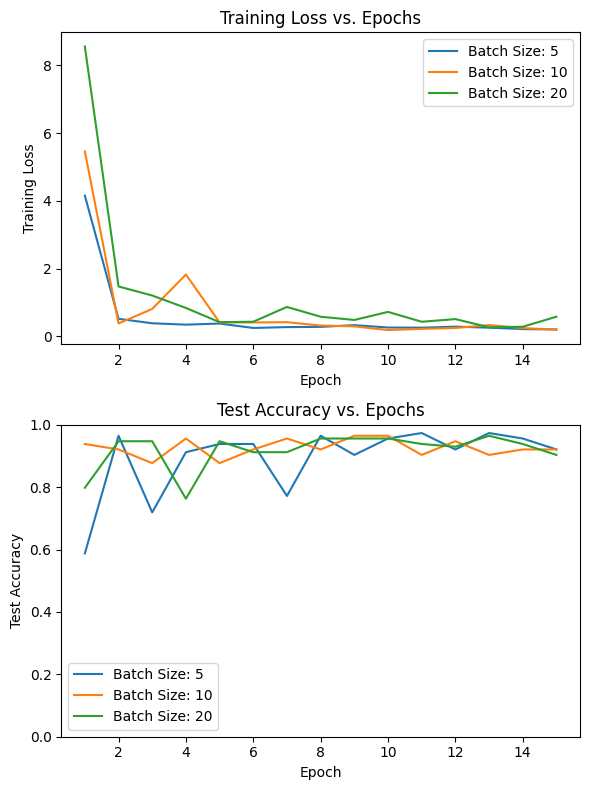

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt

# Check for GPU (CUDA) availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#from https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape", X_train.shape)


# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create a custom dataset
class breast_cancer(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and data loaders
train_dataset = breast_cancer(X_train, y_train)
test_dataset = breast_cancer(X_test, y_test)


# Define the neural Network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)  # Input size is 30 for Breast Cancer dataset
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train(trainloader, valloader):
    # Initialize the model, criterion, and optimizer
    net = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    train_losses = []
    val_losses = []
    tot_accuracy = []
    start_time = time.time()  # Record start time for training
    net.train()
    for epoch in range(num_epochs):
        running_train_loss = 0.0

        total_train_batches = len(trainloader)
        total_val_batches = len(valloader)

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / total_train_batches
        train_losses.append(epoch_train_loss)

        # Validation loop
        net.eval()
        running_val_loss = 0.0
        val_accuracy = 0
        total = 0
        total_correct_val = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()


        epoch_val_loss = running_val_loss / total_val_batches
        val_accuracy = total_correct_val / total

        print('[Epoch %d] Training loss: %.3f | Validation loss: %.3f | Validation Accuracy: %.3f' \
              % (epoch + 1, epoch_train_loss, epoch_val_loss, val_accuracy))

        val_losses.append(epoch_val_loss)
        tot_accuracy.append(val_accuracy)

    end_time = time.time()  # Record end time for training
    total_time = end_time - start_time  # Calculate total training time
    print("Total training time:", total_time, "seconds")  # Print total training time

    return train_losses, val_losses, tot_accuracy


# Loop over different batch sizes
batch_sizes = [5, 10, 20]
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
num_epochs = 15

for i, batch_size in enumerate(batch_sizes):
    print("Batch size:", batch_size)

    # Define the training and validation loaders using the subsets
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    train_losses, val_losses, tot_accuracy = train(trainloader, valloader)

    ax = axs[0]

    ax.plot(range(1, num_epochs + 1), train_losses,
            label=f'Batch Size: {batch_size}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title(f'Training Loss vs. Epochs')
    ax.legend()

    ax = axs[1]
    ax.plot(range(1, num_epochs + 1), tot_accuracy,
            label=f'Batch Size: {batch_size}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'Test Accuracy vs. Epochs')
    ax.set_ylim([0, 1])  # Set y-range from 0 to 1
    ax.legend()

plt.tight_layout()
plt.show()

# Comment about optimizer
The dataset contains the following features:

Radius (mean): 6.98 - 28.11
Texture (mean): 9.71 - 39.28
Perimeter (mean): 43.79 - 188.5
Area (mean): 143.5 - 2501.0
Smoothness (mean): 0.053 - 0.163
Compactness (mean): 0.019 - 0.345
Concavity (mean): 0.0 - 0.427
Concave points (mean): 0.0 - 0.201 and so on

As you can notice, the features have significantly different scales, so SGD might converge slowly or get stuck in local minima. If you want to use SGD as the optimizer, you need to rescale the features to a range of 0-1. If you don't rescale the features, you should use Adam as the optimizer since it is less sensitive to the scale due to the adaptive learning rate mechanism of it.


# Problem 2: Multi-class Classification

This problem involves 10-class classification using the MNIST dataset from torchvision.
1. Write a Python script to implement a MLP with 3 hidden layers with 10, 10 , 10 hidden
units for the task of multiclass classification.
2. Using the MNIST dataset, train the model for 20 epochs using a 80-20 random split
between training and testing; evaluate the model's performance by plotting the training
loss function and the classification accuracy (on the test set) with respect to the
number of epochs. Compare the performance for 3 different batch sizes.

Batch size: 128
[Epoch 1] Training loss: 1.933 | Validation loss: 1.340 | Validation Accuracy: 0.779
[Epoch 2] Training loss: 1.233 | Validation loss: 0.813 | Validation Accuracy: 0.837
[Epoch 3] Training loss: 0.974 | Validation loss: 0.638 | Validation Accuracy: 0.858
[Epoch 4] Training loss: 0.861 | Validation loss: 0.550 | Validation Accuracy: 0.872
[Epoch 5] Training loss: 0.791 | Validation loss: 0.494 | Validation Accuracy: 0.882
[Epoch 6] Training loss: 0.741 | Validation loss: 0.456 | Validation Accuracy: 0.889
[Epoch 7] Training loss: 0.703 | Validation loss: 0.426 | Validation Accuracy: 0.894
[Epoch 8] Training loss: 0.677 | Validation loss: 0.403 | Validation Accuracy: 0.898
[Epoch 9] Training loss: 0.656 | Validation loss: 0.384 | Validation Accuracy: 0.902
[Epoch 10] Training loss: 0.638 | Validation loss: 0.369 | Validation Accuracy: 0.905
[Epoch 11] Training loss: 0.622 | Validation loss: 0.356 | Validation Accuracy: 0.907
[Epoch 12] Training loss: 0.610 | Validation lo

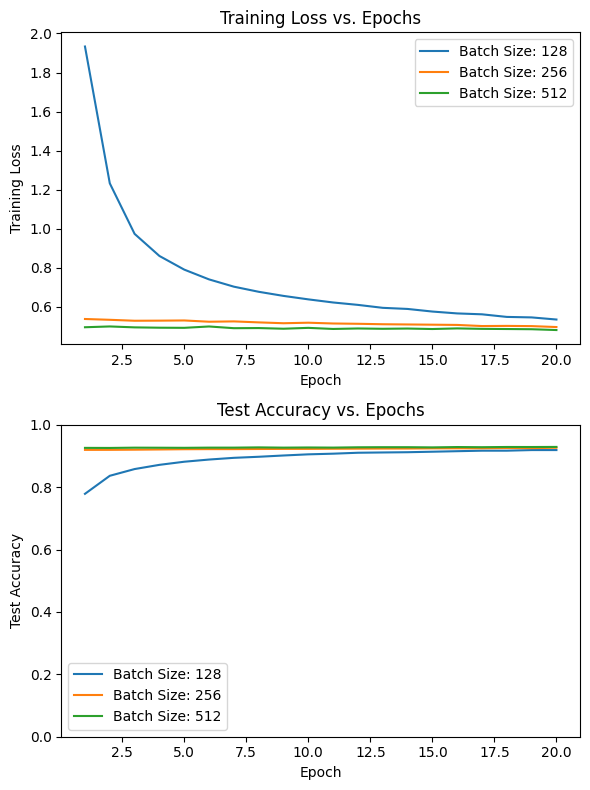

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import Subset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import time

# Check if CUDA is available, otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters
input_size = 784
num_classes = 10
num_epochs = 20
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='../../data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='../../data',
    train=False,
    transform=transforms.ToTensor()
)


def train(Net, trainloader, valloader, device):
    train_losses = []
    val_losses = []
    tot_accuracy = []
    start_time = time.time()  # Record start time for training
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        val_accuracy = 0
        total_correct_val = 0
        total_train_batches = len(trainloader)
        total_val_batches = len(valloader)

        # Training loop
        Net.train()
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = Net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / total_train_batches
        train_losses.append(epoch_train_loss)
        # Validation loop
        val_accuracy = 0
        total = 0
        total_correct_val = 0
        Net.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(valloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = Net(inputs)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()


        epoch_val_loss = running_val_loss / total_val_batches
        val_accuracy = total_correct_val / total

        print('[Epoch %d] Training loss: %.3f | Validation loss: %.3f | Validation Accuracy: %.3f' \
              % (epoch + 1, epoch_train_loss, epoch_val_loss, val_accuracy))

        val_losses.append(epoch_val_loss)
        tot_accuracy.append(val_accuracy)

    end_time = time.time()  # Record end time for training
    total_time = end_time - start_time  # Calculate total training time
    print("Total training time:", total_time, "seconds")  # Print total training time

    return train_losses, val_losses, tot_accuracy



# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Loop over different batch sizes
batch_sizes = [128, 256, 512]
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

for i, batch_size in enumerate(batch_sizes):
    print("Batch size:", batch_size)

    # Define the training and validation loaders using the subsets
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train the model
    train_losses, val_losses, tot_accuracy = train(model, trainloader, valloader, device)

    ax = axs[0]
    ax.plot(range(1, num_epochs + 1), train_losses,
            label=f'Batch Size: {batch_size}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title(f'Training Loss vs. Epochs')
    ax.legend()

    ax = axs[1]
    ax.plot(range(1, num_epochs + 1), tot_accuracy,
            label=f'Batch Size: {batch_size}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'Test Accuracy vs. Epochs')
    ax.set_ylim([0, 1])  # Set y-range from 0 to 1
    ax.legend()

plt.tight_layout()
plt.show()